# 線形判別分析 (LDA) の理論とPython実装

このノートブックでは、ご提示いただいたZennのドキュメントを参考に、線形判別分析 (Linear Discriminant Analysis, LDA) の数学的理論を整理し、Pythonの`scikit-learn`ライブラリを用いて実装、評価までを行います。

LDA（正準判別分析, CDA とも呼ばれます）は、K個（K≧2）のグループを最もよく分離するような低次元の軸（正準判別軸）を見つける手法です。

**目的:**
1.  **数学的理論の確認:** $S_W$（クラス内共分散行列）と $S_B$（クラス間共分散行列）を定義し、フィッシャーの基準を理解します。
2.  **サンプルデータの準備:** IrisデータセットをCSVとして擬似的に生成します。
3.  **実装:** `scikit-learn` を用いてLDAを学習し、データを低次元（2次元）に射影します。
4.  **評価:** 統計準1級で問われるような、モデルの分類性能を評価する手法（混同行列、正解率、適合率、再現率）を解説・実行します。

In [ ]:
import pandas as pd
from sklearn.datasets import load_iris

# 1. Irisデータセットのロード
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

# 2. Pandas DataFrameの作成
df = pd.DataFrame(data=X, columns=iris.feature_names)
df['species_id'] = y
df['species_name'] = df['species_id'].map(lambda id: target_names[id])

# 3. サンプルCSVファイルとして保存
csv_filename = 'iris_sample.csv'
df.to_csv(csv_filename, index=False)

print(f"'{csv_filename}' を生成しました。")
print("--- データ（先頭5行） ---")
print(df.head())
print("\n--- クラスの内訳 ---")
print(df['species_name'].value_counts())

'iris_sample.csv' を生成しました。
--- データ（先頭5行） ---
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species_id species_name  
0           0       setosa  
1           0       setosa  
2           0       setosa  
3           0       setosa  
4           0       setosa  

--- クラスの内訳 ---
species_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


## 2. LDAの数学的理論（フィッシャーの基準）

LDAは、K個のグループ（クラス $C_k$）に分類された $p$ 次元のデータ $x$ について、射影後の「クラス間変動」を「クラス内変動」で割った比 $J(w)$ を最大化する射影軸 $w$ を見つける問題です。

### 定義

* **クラス $C_k$ の平均ベクトル:** $\mu_k$
* **全データの平均ベクトル:** $\mu$
* **クラス $C_k$ のサンプル数:** $N_k$

#### 1. クラス内共分散行列 $S_W$ (Within-class covariance matrix)
各クラス内でのデータのばらつきの総和です。各データの、所属するクラスの平均 $\mu_k$ からのズレを測ります。

$$S_W = \sum_{k=1}^K S_k = \sum_{k=1}^K \sum_{i \in C_k} (x_i - \mu_k)(x_i - \mu_k)^T$$

$S_W$ が小さいほど、各クラスは密にまとまっている（判別しやすい）ことを意味します。

#### 2. クラス間共分散行列 $S_B$ (Between-class covariance matrix)
各クラスの平均 $\mu_k$ が、全データの平均 $\mu$ からどれだけ離れているかの（サンプルサイズ $N_k$ で重み付けした）変動です。

$$S_B = \sum_{k=1}^K N_k (\mu_k - \mu)(\mu_k - \mu)^T$$

$S_B$ が大きいほど、クラスの平均どうしが互いに離れている（判別しやすい）ことを意味します。

### フィッシャーの基準と解

LDAは、射影軸 $w$ にデータを射影したときの変動比（フィッシャーの基準） $J(w)$ を最大化します。

$$J(w) = \frac{w^T S_B w}{w^T S_W w}$$

この $J(w)$ を最大化する $w$ は、以下の**一般化固有値問題**の解として得られます。

$$S_B w = \lambda S_W w$$

$S_W$ が正則（逆行列を持つ）ならば、これは $S_W^{-1} S_B w = \lambda w$ という標準的な固有値問題に帰着します。

得られる固有値 $\lambda_j$ が大きい順に対応する固有ベクトル $w_j$ が、第1正準判別軸、第2正準判別軸... となります。これらの軸が、グループを最もよく分離する「新しい座標軸」です。

**次元:**
判別軸の数 $m$ は、変数の数 $p$ と (クラス数 $K-1$) のうち、小さい方になります。
$m \le \min(p, K-1)$

今回のIrisデータ ($p=4, K=3$) では、$m = \min(4, 3-1) = 2$ となり、最大2本の判別軸（2次元）に次元削減できます。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 描画スタイルの設定
# plt.rcParams['font.family'] = 'Hiragino Sans' # Mac用
plt.rcParams['font.family'] = 'Yu Gothic' # Windows用
# plt.rcParams['font.family'] = 'IPAGothic' # Linux用
plt.rcParams['axes.unicode_minus'] = False # マイナス記号の文字化け防止
sns.set(font='Hiragino Sans')

# 1. データのロード
df = pd.read_csv('iris_sample.csv')

# 2. 特徴量 (X) とターゲット (y) に分離
X = df.drop(['species_id', 'species_name'], axis=1)
y = df['species_id']
target_names = df['species_name'].unique()
print("特徴量の形状:", X.shape)
print("ターゲットの形状:", y.shape)

# 3. 訓練データとテストデータに分割 (統計的評価の基本)
# 統計準1級レベルでは、未知のデータに対する性能（汎化性能）を測るため、
# データを訓練用とテスト用に分けることが必須です。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"訓練データ: {X_train.shape}, テストデータ: {X_test.shape}")

# 4. 標準化 (Standardization)
# LDAは分散を扱うため、各特徴量のスケール（単位）を揃えることが推奨されます。
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # 訓練データの平均・分散でテストデータも変換

特徴量の形状: (150, 4)
ターゲットの形状: (150,)
訓練データ: (105, 4), テストデータ: (45, 4)


In [3]:
# 1. LDAモデルのインスタンス化
# n_components: 抽出する判別軸の数。K=3 のため、最大 K-1=2 を指定。
lda = LinearDiscriminantAnalysis(n_components=2)

# 2. モデルの学習 (fit)
# fitメソッド内で、S_W と S_B が計算され、固有値問題が解かれます。
lda.fit(X_train_scaled, y_train)

# 3. 訓練データの次元削減 (transform)
# 4次元 -> 2次元の正準判別空間に射影
X_train_lda = lda.transform(X_train_scaled)

print("LDAによる次元削減後の形状:", X_train_lda.shape)

# 4. 判別寄与率の確認
# (統計準1級レベル): 各軸がどれだけ全体の判別能力（クラス間分散）を説明しているか
print("\n各判別軸の寄与率 (Explained Variance Ratio):")
print(f"第1軸 (LD1): {lda.explained_variance_ratio_[0]:.4f}")
print(f"第2軸 (LD2): {lda.explained_variance_ratio_[1]:.4f}")
print(f"累積寄与率: {lda.explained_variance_ratio_.sum():.4f}")

LDAによる次元削減後の形状: (105, 2)

各判別軸の寄与率 (Explained Variance Ratio):
第1軸 (LD1): 0.9882
第2軸 (LD2): 0.0118
累積寄与率: 1.0000


findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
c:\Users\iniad\anaco

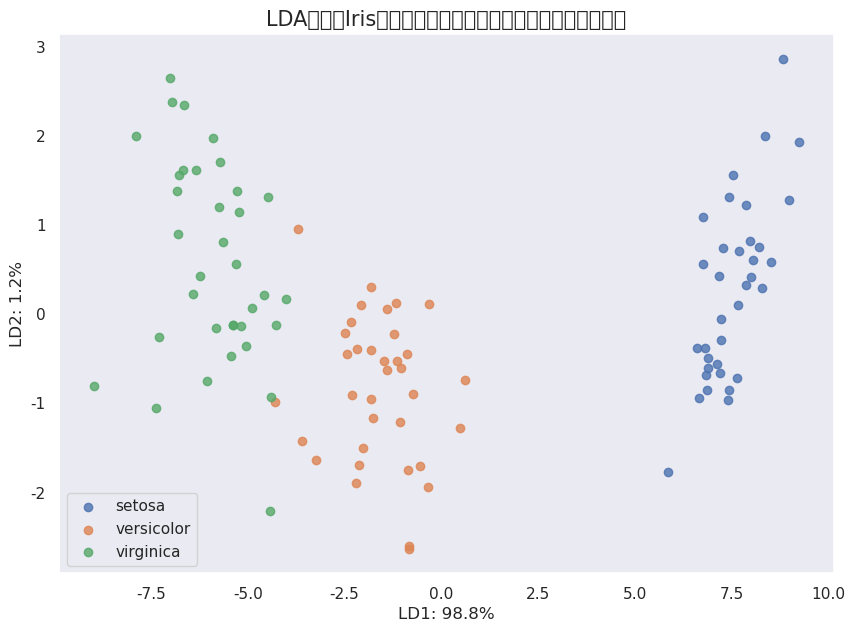

In [8]:
# 2次元の判別空間にプロットする
plt.figure(figsize=(10, 7))

# ターゲット（クラス）ごとに色分けして散布図を描画
for i, name in enumerate(target_names):
    plt.scatter(X_train_lda[y_train == i, 0],  # 第1判別軸 (LD1)
                X_train_lda[y_train == i, 1],  # 第2判別軸 (LD2)
                alpha=0.8,
                label=name)

plt.title('LDAによるIrisデータセットの次元削減結果（訓練データ）', fontsize=15)
plt.xlabel(f'LD1: {lda.explained_variance_ratio_[0]:.1%}')
plt.ylabel(f'LD2: {lda.explained_variance_ratio_[1]:.1%}')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.grid()
plt.show()

## 3. モデルの分類性能の評価

LDAは次元削減の手法であると同時に、強力な「分類器」でもあります。
`fit`されたLDAモデルは、新しいデータ（テストデータ）がどのクラスに属するかを予測する `predict` メソッドを持ちます。

ここでは、訓練時に使用しなかった**テストデータ**を用いて、モデルの真の分類性能（汎化性能）を評価します。

**評価指標（統計準1級レベル）:**
* **正解率 (Accuracy):** 全データのうち、正しく分類できた割合。
* **混同行列 (Confusion Matrix):** 予測と正解のクラスを対比させた表。モデルが「どのクラスとどのクラスを間違えやすいか」を詳細に分析できます。
* **適合率 (Precision):** モデルが「陽性(Positive)」と予測したもののうち、実際に陽性であった割合。（誤検知の少なさ）
* **再現率 (Recall):** 実際に「陽性(Positive)」であったもののうち、モデルが陽性と予測できた割合。（見逃しの少なさ）
* **F1値 (F1-Score):** 適合率と再現率の調和平均。両者のバランスを評価する指標。

In [5]:
# 1. テストデータ (X_test) を使って予測を実行
# X_testも、X_trainと同じスケーラーで標準化 (X_test_scaled) したものを使う
y_pred = lda.predict(X_test_scaled)

# 2. 正解 (y_test) と予測 (y_pred) を比較
print("--- テストデータによる予測結果 ---")
print("正解 (y_test):", y_test.values[:20])
print("予測 (y_pred):", y_pred[:20])

# 3. 正解率 (Accuracy) の計算
accuracy = accuracy_score(y_test, y_pred)
print(f"\n正解率 (Accuracy): {accuracy:.4f} ({accuracy:.1%})")

--- テストデータによる予測結果 ---
正解 (y_test): [2 1 2 1 2 2 1 1 0 2 0 0 2 2 0 2 1 0 0 0]
予測 (y_pred): [2 1 1 1 2 2 1 1 0 2 0 0 2 2 0 2 1 0 0 0]

正解率 (Accuracy): 0.9778 (97.8%)


findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
c:\Users\iniad\anaconda3\envs\ds2024\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\iniad\anaconda3\envs\ds2024\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
c:\Users\iniad\anaconda3\envs\ds2024\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\iniad\anaconda3\envs\ds2024\lib\sit


--- 混同行列 (Confusion Matrix) ---
                予測: setosa  予測: versicolor  予測: virginica
正解: setosa              15               0              0
正解: versicolor           0              15              0
正解: virginica            0               1             14


findfont: Font family 'Hiragino Sans' not found.
c:\Users\iniad\anaconda3\envs\ds2024\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\iniad\anaconda3\envs\ds2024\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
c:\Users\iniad\anaconda3\envs\ds2024\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\iniad\anaconda3\envs\ds2024\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E

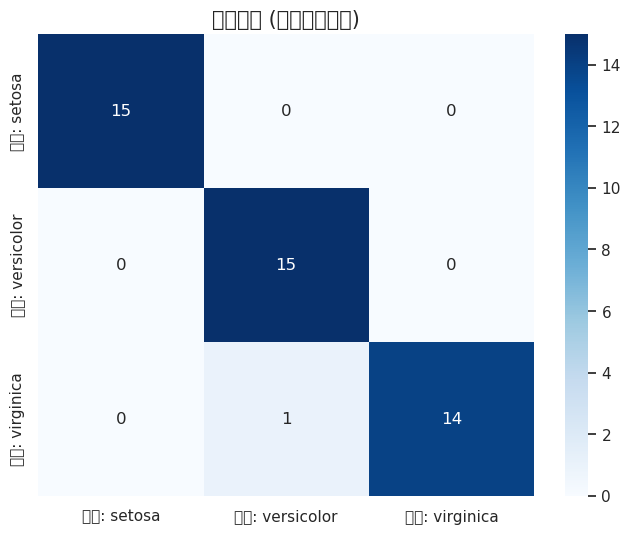

In [6]:
# 1. 混同行列の計算
cm = confusion_matrix(y_test, y_pred)

# 2. Pandas DataFrameに変換（見やすくするため）
cm_df = pd.DataFrame(cm, 
                     index=[f"正解: {name}" for name in target_names],
                     columns=[f"予測: {name}" for name in target_names])

print("\n--- 混同行列 (Confusion Matrix) ---")
print(cm_df)

# 3. ヒートマップによる可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('混同行列 (テストデータ)', fontsize=15)
plt.show()

### 混同行列の読み方

* **対角成分 (左上から右下):** 正しく分類できたサンプルの数。
    * (正解: setosa, 予測: setosa)
    * (正解: versicolor, 予測: versicolor)
    * (正解: virginica, 予測: virginica)
* **非対角成分:** 間違って分類されたサンプルの数（分類エラー）。
    * 例えば「正解: virginica」の行の「予測: versicolor」の列に `1` とあれば、それは「本当はvirginicaなのに、versicolorと間違って予測された」サンプルが1つあったことを意味します。

この行列を見ることで、モデルが `setosa` は完璧に分類できているが、`versicolor` と `virginica` を時々混同している、といった**エラーの傾向**を詳細に把握できます。

In [7]:
# 適合率 (Precision), 再現率 (Recall), F1値 (F1-score) をまとめて出力
report = classification_report(y_test, y_pred, target_names=target_names)

print("\n--- 分類レポート (Classification Report) ---")
print(report)

print("\n--- 指標の解説 ---")
print(f"precision (適合率): \"{target_names[1]}\" と予測したうち、本当に \"{target_names[1]}\" だった割合")
print(f"recall (再現率):    本当に \"{target_names[1]}\" だったもののうち、正しく \"{target_names[1]}\" と予測できた割合")
print("f1-score (F1値):      適合率と再現率の調和平均。トレードオフを考慮した総合評価。")
print("support (件数):     各クラスのテストデータにおける実サンプル数。")
print("accuracy (正解率):  全テストデータのうち、正しく予測できた割合。")
print("macro avg:         全クラスの指標の単純平均。")
print("weighted avg:      各クラスのサンプル数(support)で重み付けした平均。")


--- 分類レポート (Classification Report) ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45


--- 指標の解説 ---
precision (適合率): "versicolor" と予測したうち、本当に "versicolor" だった割合
recall (再現率):    本当に "versicolor" だったもののうち、正しく "versicolor" と予測できた割合
f1-score (F1値):      適合率と再現率の調和平均。トレードオフを考慮した総合評価。
support (件数):     各クラスのテストデータにおける実サンプル数。
accuracy (正解率):  全テストデータのうち、正しく予測できた割合。
macro avg:         全クラスの指標の単純平均。
weighted avg:      各クラスのサンプル数(support)で重み付けした平均。
